In [ ]:
%matplotlib inline

Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss
and make updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a `torch.*Tensor`.

-   For images, packages such as Pillow, OpenCV are useful
-   For audio, packages such as scipy and librosa
-   For text, either raw Python or Cython based loading, or NLTK and
    SpaCy are useful

Specifically for vision, we have created a package called `torchvision`,
that has data loaders for common datasets such as ImageNet, CIFAR10,
MNIST, etc. and data transformers for images, viz.,
`torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset. It has the classes:
'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
'ship', 'truck'. The images in CIFAR-10 are of size 3x32x32, i.e.
3-channel color images of 32x32 pixels in size.

![cifar10](https://pytorch.org/tutorials/_static/img/cifar10.png)

Training an image classifier
----------------------------

We will do the following steps in order:

1.  Load and normalize the CIFAR10 training and test datasets using
    `torchvision`
2.  Define a Convolutional Neural Network
3.  Define a loss function
4.  Train the network on the training data
5.  Test the network on the test data



### 1. Load and normalize [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)

Using `torchvision`, it's extremely easy to load CIFAR10

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

The output of torchvision datasets are PILImage images of range \[0,
1\]. We transform them to Tensors of normalized range \[-1, 1\].


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>If running on Windows and you get a BrokenPipeError, try settingthe num_worker of torch.utils.data.DataLoader() to 0.</p>
</div>


In [ ]:
# Define a transformation to convert the images to tensors and normalize them
# The images are normalized with a mean of 0.5 and a standard deviation of 0.5 for each color channel
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Define the batch size for loading the data
batch_size = 4

# Download and load the training set of CIFAR-10 dataset
# The data is stored in the './data' directory
# The 'transform' defined above is applied to the data
dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)

# Define the size of the validation set
val_size = 5000
train_size = len(dataset) - val_size

# Split the dataset into training and validation sets
trainset, valset = random_split(dataset, [train_size, val_size])


# Create a data loader for the training set and validation set
# This loader will iterate over the dataset and return batches of size 'batch_size'
# The data is shuffled at every epoch and 2 worker threads are used to load the data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

# Download and load the test set of CIFAR-10 dataset
# The data is stored in the './data' directory
# The 'transform' defined above is applied to the data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Create a data loader for the test set
# This loader will iterate over the dataset and return batches of size 'batch_size'
# The data is not shuffled and 2 worker threads are used to load the data
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Define the classes in the CIFAR-10 dataset
# Each class is a type of object that can be found in the images
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Print the length of the datasets
print(f"Length of training dataset: {len(trainset)}")
print(f"Length of validation dataset: {len(valset)}")
print(f"Length of test dataset: {len(testset)}")

Files already downloaded and verified
Files already downloaded and verified
Length of training dataset: 45000
Length of validation dataset: 5000
Length of test dataset: 10000


**Transforms Function**: <br/>
-The transforms.Compose function defines a series of transformations to be applied to the dataset <br/>
-First, the images are converted from numpy arrays to PyTorch tensors using transforms.ToTensor(), which scales the pixel values from 0 to 1 <br/>
-Then, transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) normalizes these values to a range of -1 to 1 by subtracting 0.5 and dividing by 0.5 for each color channel (RGB) <br/>
**Dataset Definition**: <br/>
-The CIFAR-10 dataset is loaded using the torchvision.datasets.CIFAR10 class <br/>
-The dataset is downloaded from the internet if it is not already present in the specified directory (./data) <br/>
-train=True argument loads the training set, and train=False argument loads the test set <br/>
-The same transformations (conversion to tensor and normalization) are applied to both the training and test datasets <br/>
**DataLoaders**: <br/>
-DataLoader objects (trainloader and testloader) are created for both the training and test sets <br/>
-The DataLoader handles batching, shuffling, and parallel data loading <br/>
-batch_size=4 specifies that the data will be loaded in batches of 4 samples <br/>
-shuffle=True for the training set ensures that the data is shuffled at the beginning of each epoch, promoting better training by reducing overfitting <br/>
-shuffle=False for the test set ensures that the data is not shuffled, which is important for evaluating the model consistently <br/>
-num_workers=2 specifies that two worker threads will be used to load the data, which can speed up data loading <br/>
**Classes**: <br/>
The classes tuple defines the ten different object classes in the CIFAR-10 dataset (e.g., 'plane', 'car', 'bird', etc.) <br/>

Let us show some of the training images, for fun.


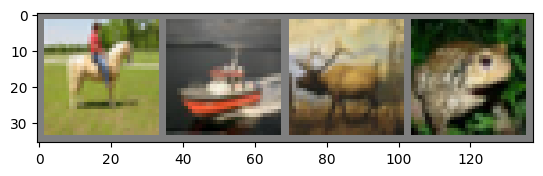

horse ship  deer  frog 


In [ ]:
import matplotlib.pyplot as plt # Library used for plotting
import numpy as np # Library used for array manipulation

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize the image (reversing the normalization applied earlier)
    npimg = img.numpy()  # Convert the image to a NumPy array
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Transpose the image dimensions from (C, H, W) to (H, W, C) for plotting
    plt.show() # Display the image


# Get some random training images
dataiter = iter(trainloader) # Create an iterator from the training DataLoader
images, labels = next(dataiter) # Get the next batch of images and labels

# Show images
imshow(torchvision.utils.make_grid(images)) # Make a grid of images and display them using the imshow function
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size))) # Print the class labels of the images

**Data Loading and Preprocessing(Review)**: <br/>
-When the data is loaded, it undergoes a series of transformations: <br/>
(1)Conversion to Tensor: <br/>
The images are converted from numpy arrays to PyTorch tensors <br/>
(2)Normalization: <br/>
The images are normalized to have a mean of 0.5 and a standard deviation of 0.5 for each color channel. This normalization scales the pixel values to a range of -1 to 1 <br/>
**Visualization**: <br/>
-To visualize the images, we need to reverse (or backtrack) these preprocessing steps: <br/>
(1)Denormalization: <br/>
The images are denormalized by reversing the normalization step. <br/>
If the normalization was img = (img - mean) / std, then the denormalization is img = img * std + mean. Since the mean and standard deviation used were 0.5, the denormalization is img = img * 0.5 + 0.5 <br/>
(2)Conversion to NumPy Array: <br/>
The tensor is converted back to a numpy array because Matplotlib expects images in numpy array format <br/>
(3)Change the Dimensions:  <br/>
The image dimensions are transposed from (C, H, W) to (H, W, C) to match the format expected by Matplotlib, where C is the number of channels, H is the height, and W is the width <br/>
**Visualizing a Batch**: <br/>
-To ensure the images were loaded and preprocessed correctly, we visualize a batch of images <br/>
-We create an iterator from the DataLoader and fetch a random batch of images and their corresponding labels <br/>
-Matplotlib is used for visualization as it is a robust and widely-used library for plotting and displaying images in Python <br/>

# 2. Define a Convolutional Neural Network
========================================

Copy the neural network from the Neural Networks section before and
modify it to take 3-channel images (instead of 1-channel images as it
was defined).


In [ ]:
import torch.nn as nn # Provides various classes for building neural networks
import torch.nn.functional as F # Provides functions for neural network operations, like activation functions, etc.


class Net(nn.Module): # Defines a new neural network class Net which inherits from nn.Module
    def __init__(self):
        super().__init__() # Constructor for class
        self.conv1 = nn.Conv2d(3, 6, 5) # First convolutional layer: 3 input channels (RGB image), 6 output channels, and a kernel size of 5
        self.pool = nn.MaxPool2d(2, 2) # Max pooling layer: 2x2 window and a stride of 2
        self.conv2 = nn.Conv2d(6, 16, 5) # Second convolutional layer: 6 input channels, 16 output channels, and a kernel size of 5
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # First fully connected layer: input size 1655 and output size 120
        self.fc2 = nn.Linear(120, 84) # Second fully connected layer: input size 120 and output size 84
        self.fc3 = nn.Linear(84, 10) # Third fully connected layer with input size 84 and output size 10 (corresponding to the 10 classes of CIFAR-10)

    def forward(self, x): # Forward pass of the network
        x = self.pool(F.relu(self.conv1(x))) # First convolutional layer => ReLU activation function => max pooling
        x = self.pool(F.relu(self.conv2(x))) # Second convolutional layer => ReLU activation function => max pooling
        x = torch.flatten(x, 1) # Flattens the output from the convolutional layers into a single vector, except for the batch dimension
        x = F.relu(self.fc1(x)) # First fully connected layer => ReLU activation function
        x = F.relu(self.fc2(x)) # Second fully connected layer => ReLU activation function
        x = self.fc3(x) # Third fully connected layer which produces the output logits for the 10 classes
        return x


net = Net()

## Computing Dimensions After Convolution and Pooling
**[Convolution Layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)** <br/>
Arguments: (in_channels, out_channels, kernel_size) <br/>
Default stride=1, padding=0  <br/>
Formula: <br/>
$$ \text{Output_size} = \frac{(\text{Input_size} - \text{Kernel_size} + 2 \times \text{Padding})}{\text{Stride}} + 1 ] $$

**[Pooling Layer](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)** <br/>
Arguments: (in_channels, out_channels, kernel_size) <br/>
Formula: <br/>
$$ \text{Output_size} = \frac{(\text{Input_size} - \text{Kernel_size} )}{\text{Stride}} + 1 ] $$

**Calculation from the code** <br/>
(1)conv1: <br/>
Input Image Size: 32 X 32 X 3 <br/>
cal1 = ((32 - 5 + (2 x 0)) / 1 ) + 1 = 28 <br/>
cal2 = 32 - ((5/2)x2) = 28 <br/>
Output Image Size: 28 X 28 X 6 <br/>
(2)pool: <br/>
Input Image Size: 28 X 28 X 6 <br/>
cal1 = ((28 - 2) / 2 ) + 1 = 14 <br/>
cal2 = 28 / 2 = 14 <br/>
Output Image Size: 14 X 14 X 6 <br/>
(3)conv2: <br/>
Input Image Size: 14 X 14 X 6 <br/>
cal1 = ((14 - 5 + (2 x 0)) / 1 ) + 1 = 10 <br/>
cal2 = 14 - ((5/2)x2) = 10 <br/>
Output Image Size: 10 X 10 X 16 <br/>
(4)pool: <br/>
Input Image Size: 10 X 10 X 16 <br/>
cal1 = ((10 - 2) / 2 ) + 1 = 5 <br/>
cal2 = 10 / 2 = 5 <br/>
Output Image Size: 5 X 5 X 16 <br/>
(5)fc1: <br/>
Input Vector Size = 5 x 5 x 16 <br/>
Output Vector Size: 120 <br/>
(6)fc2: <br/>
Input Vector Size = 120 <br/>
Output Vector Size: 84 <br/>
(7)fc3: <br/>
Input Vector Size = 84 <br/>
Output Vector Size: 10 <br/>



## Basic Concepts
**Convolution Layer** <br/>
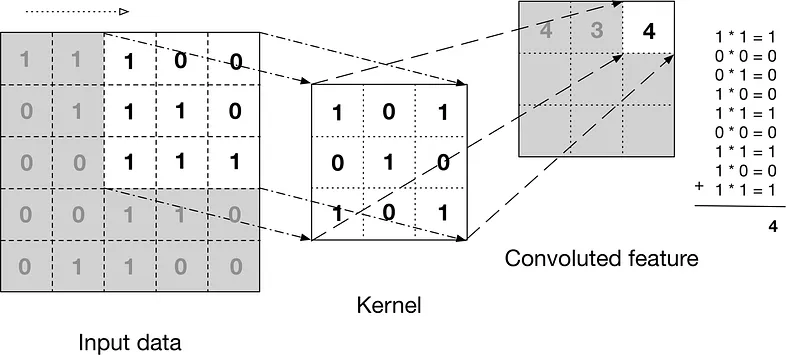 <br/>
(Image Reference: https://medium.com/machine-learning-for-li/different-convolutional-layers-43dc146f4d0e) <br/>
-Well-suited for image processing, because they handle 2-Dimensional forms of input. In each layer of the neural network, a series of filters(kernels) are applied to the image <br/>
-Since 1D data loses the locality of features in an image, these features cannot be utilized during the training process <br/>
-The result of performing a convolution is called a feature map. The applied kernel (mask, filter) is a Laplacian kernel, which is used for edge detection. Therefore, the result of the convolution operation can be considered to have generated edge values as feature values <br/>
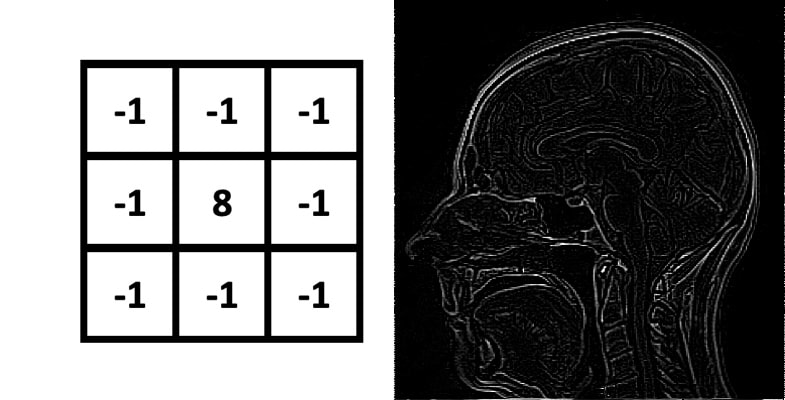 <br/>
(Image Reference: https://mriquestions.com/what-is-convolution.html) <br/>
-In a convolutional neural network, kernels are overlaid on each pixel of the input layer. The value X from the previous layer is multiplied by each kernel
W and summed to become WX+b <br/>
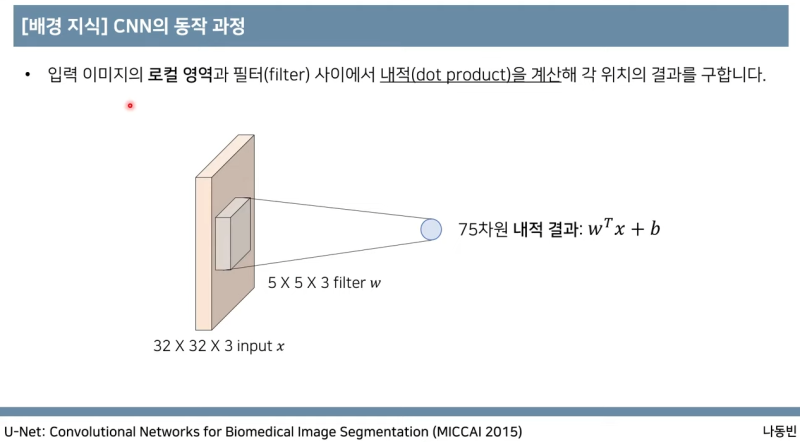 <br/>
(Image Reference: https://blog.naver.com/allbareunkr/222827999300?trackingCode=rss) <br/>
-This calculated value passes through an activation function such as ReLU(), and is stored at the same position in the next layer as ReLU(WX + b) <br/>
-Multiple filters can be used <br/>
-The values of the filters are not predetermined but are learned <br/>
=> self.conv1 = nn.Conv2d(3, 6, 5) (5 filters are applied) <br/>
-The values of the filters are not predetermined but are learned <br/>
Convolutional Layers: <br/>
Instead of a single weight w, we have a filter (or kernel) W, which is a small matrix (e.g., 3x3, 5x5). This filter slides over the input image to produce a feature map <br/>
The operation is mathematically expressed as:
Feature map=W*X+b where W is the filter, X is the input image, and * denotes the convolution operation <br/>
Training Filters: <br/>
The values in the filter W and the bias b are not predetermined. They are learned during the training process. These filters start with random values and are adjusted during training using backpropagation and gradient descent to minimize the loss function. Over time, the filters learn to extract relevant features from the images, such as edges, textures, and more complex patterns <br/>
-Stride is the distance over which the kernel is applied. If the stride is 1, the kernel moves 1 pixel at a time when it is applied. If the stride is 2, it means the kernel is applied to every other pixel, skipping one pixel each time <br/>
-Padding is a technique used to handle the edges of an image and to prevent the feature map from getting smaller and smaller <br/>
-Pooling, also known as subsampling, is the process of reducing the size of the input data <br/>
Pooling reduces the size of the layers, which speeds up computation <br/>
By reducing the size of the layers, pooling also reduces the number of parameters in the neural network. This helps decrease the risk of overfitting (A model with a large number of parameters (weights) has high capacity, meaning it can learn very complex patterns. While this is good for fitting the training data, it can also capture noise and irrelevant details that do not generalize to new data) <br/>
-Pooling ensures that the output remains unchanged even if the object in the input image shifts. This makes the network more robust to spatial variations and movements of objects within the input <br/>
Example: When max pooling is applied, it captures the most prominent feature within the pooling window. If the object in the image shifts slightly, the maximum value within the pooling window is likely to remain the same, thus maintaining the output feature map <br/>
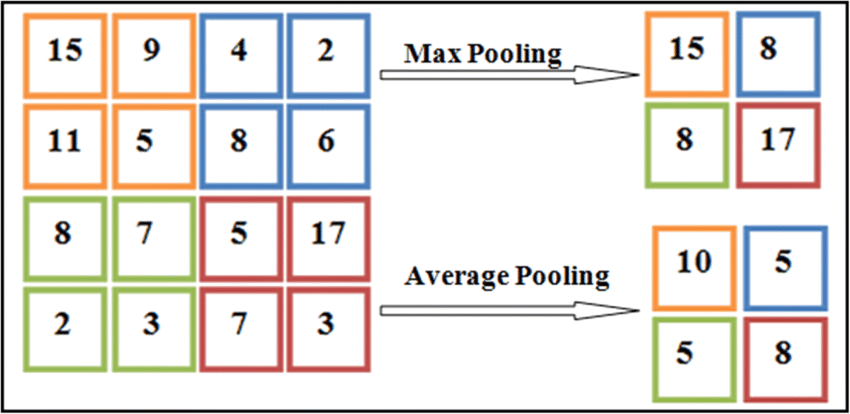 <br/>
-Activation Function <br/>
Non-Linear Transformation: <br/>
After each linear transformation (e.g., convolution), an activation function (e.g., ReLU, sigmoid, tanh) is applied: <br/>
This non-linear transformation allows the network to learn and represent more complex functions: <br/>
Hierarchical Feature Learning: <br/>
In a CNN, convolutional layers followed by activation functions help in learning hierarchical features: <br/>
For example, in image recognition, early layers might learn to detect edges and textures, while deeper layers learn to detect more complex structures like parts of objects or whole objects <br/>

**Convolutional Nerual Network Structure** <br/>
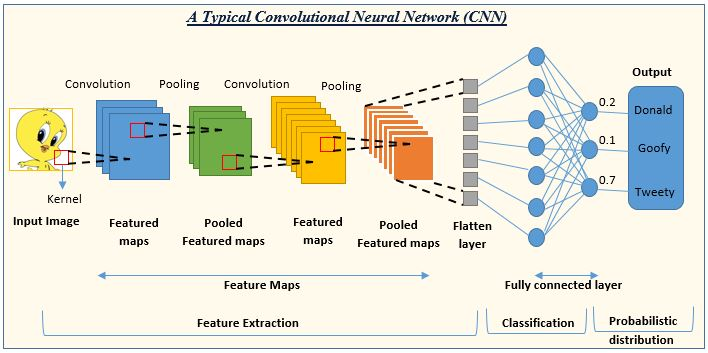 <br/>
(Image Reference: https://www.analyticsvidhya.com/blog/2022/01/convolutional-neural-network-an-overview/) <br/>
**How does our Net convolutional network looks like?** <br/>
convolution => pooling => convolution => pooling => fully connected 1 => fully connected 2 => fully connected 3 <br/>
**Convolutional Layers**: <br/>
When an input image is passed through the convolutional layer, a feature map is generated. The convolutional layers are responsible for extracting local features from the image, such as edges, textures, and shapes <br/>
**Pooling Layers**: <br/>
The feature map is then reduced using the pooling layer. Pooling layers help in reducing the spatial dimensions of the feature maps, which in turn reduces the computation required and helps in focusing on the most prominent features by leaving out minor details <br/>
This process of convolution followed by pooling is repeated multiple times to create a hierarchical extraction of features <br/>
**Fully Connected Layers**: <br/>
After the repeated convolution and pooling operations, the output is a set of feature maps that represent high-level features of the input image <br/>
At this stage, the feature maps are flattened into a 1D vector because the classification task at the end of the neural network does not require spatial information (localization) but rather the presence of certain features.
The fully connected layers (also known as dense layers) at the end of the network use these extracted features to perform the classification task <br/>
**Feature Extraction**: Convolutional layers are used to extract features from the input image. These layers detect local patterns such as edges, corners, and textures <br/>
**Dimensionality Reduction**: Pooling layers reduce the spatial dimensions of the feature maps, making the computation more efficient and emphasizing the most important features <br/>
**Repeated Process**: The process of applying convolution and pooling layers is repeated multiple times to build a hierarchy of features, from low-level to high-level <br/>
**Flattening**: Before the fully connected layers, the multi-dimensional feature maps are flattened into a 1D vector <br/>
**Classification**: The fully connected layers use the flattened feature vector to perform classification, as they do not need the spatial information of the features, only their presence <br/>

# 3. Define a Loss function and optimizer
=======================================

Let\'s use a Classification Cross-Entropy loss and SGD with momentum.


In [ ]:
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss() # Loss function suitable for multi-class classification problems
# Define the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Stochastic Gradient Descent (SGD) used as the optimization algorithm
# optimizer = optim.Adam(net.parameters(), lr=0.001)  # Adam optimizer used as the optimization algorithm

**Softmax Activation Function** <br/>
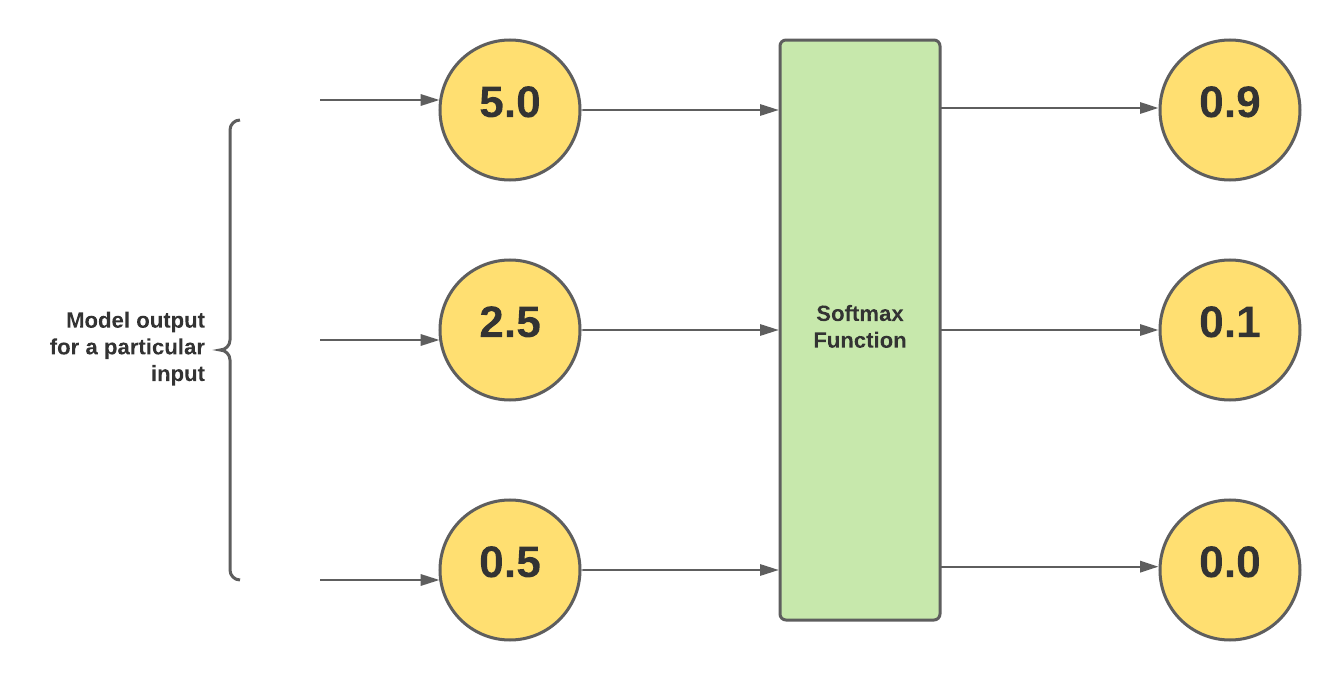 <br/>
(Image Reference: https://vitalflux.com/what-softmax-function-why-needed-machine-learning/ ) <br/>
Converts raw values (as an outcome of functions) into probabilities <br/>
-Softmax activation function converts the raw scores (logits) from the network into probabilities, which sum up to 1 <br/>
-This allows the network to represent the likelihood of each class in a way that emphasizes the most likely classes while downplaying the less likely ones <br/>
Example <br/>
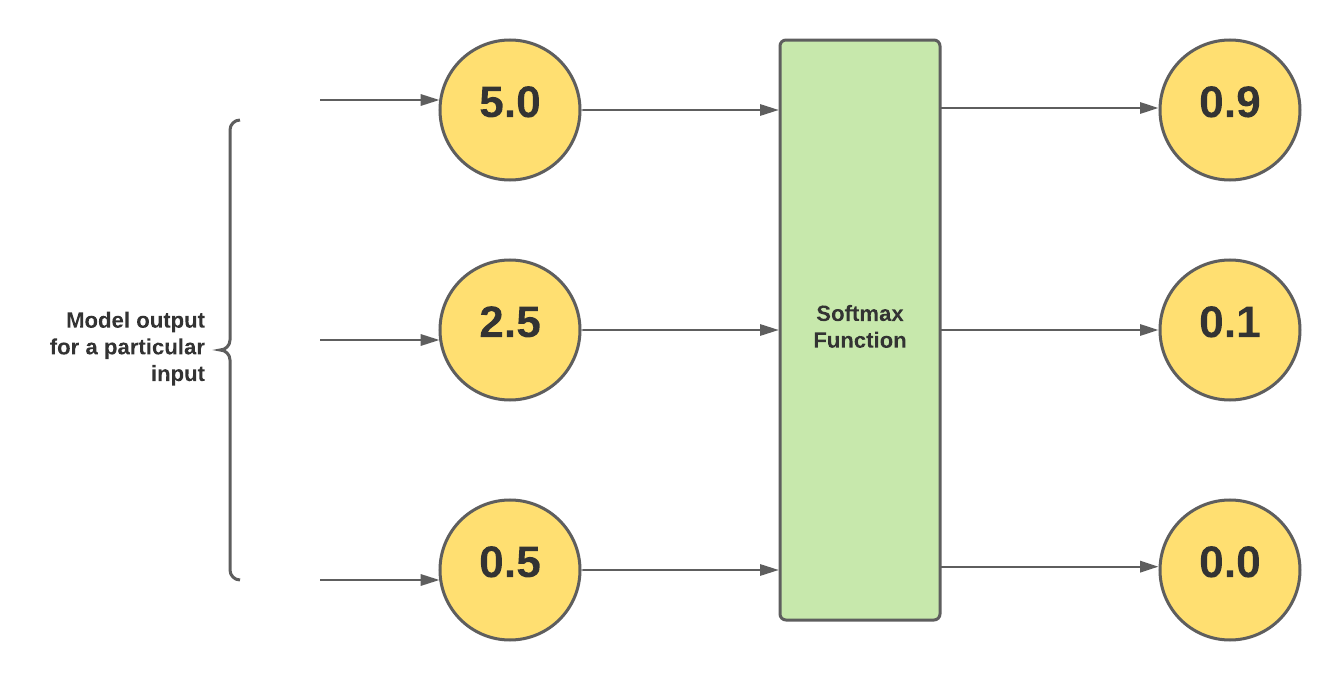 <br/>
(Image Reference: https://vitalflux.com/what-softmax-function-why-needed-machine-learning/) <br/>
Models (such as those trained using algorithms such as multi-class LDA, and multinomial logistic regression) output three different values such as 5.0, 2.5, and 0.5 for a particular input. These numbers are fed into the softmax function to convert these numbers into probabilities <br/>
-Output of the softmax function maps to a [0, 1] range. And, it maps outputs in a way that the total sum of all the output values is 1 <br/>
**Computation** <br/>
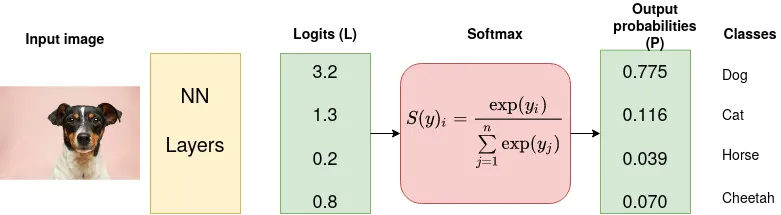 <br/>
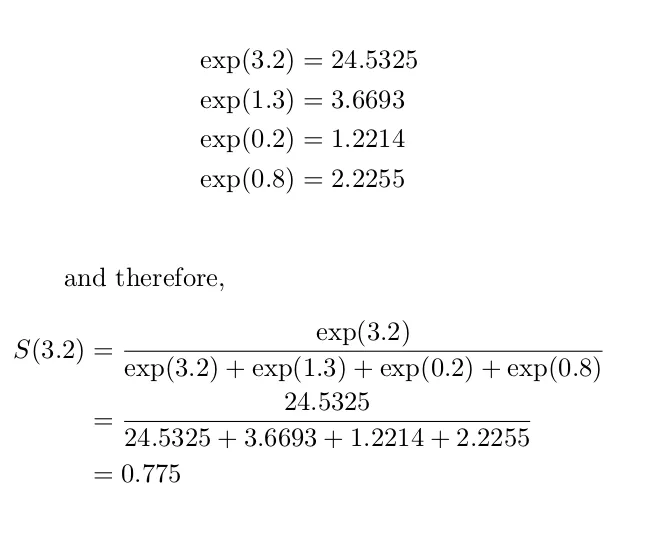 <br/>
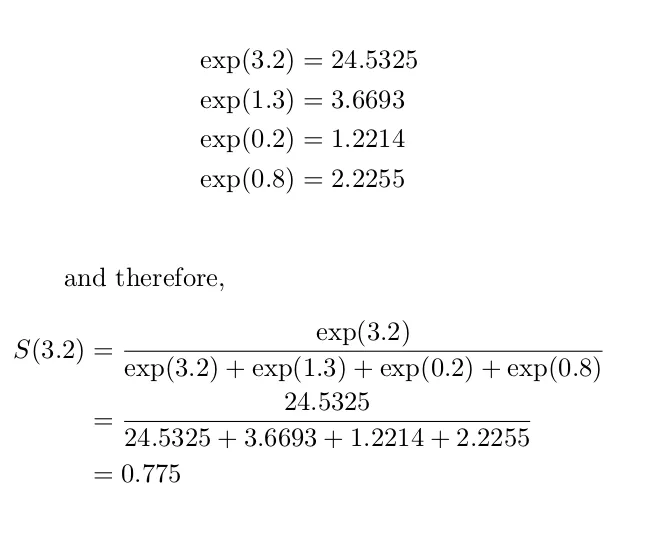 <br/>
(Image Reference: https://towardsdatascience.com/softmax-activation-function-how-it-actually-works-d292d335bd78) <br/>


**Cross Entropy Loss** <br/>
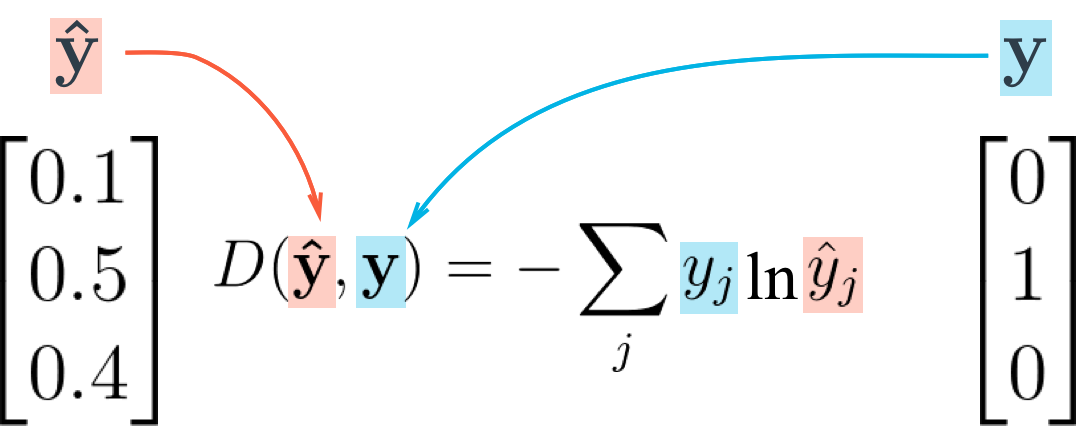 <br/>
(Image Reference: https://linked0.gitbooks.io/mlguide/content/loss-function.html) <br/>
Calculation: <br/>
-((0*log0.1)+(1*log0.5)+(0*log0.4)) = 0.693 <br/>

# 4. Train the network
====================

This is when things start to get interesting. We simply have to loop
over our data iterator, and feed the inputs to the network and optimize.


Epoch 1, Batches: 1, Train Class Loss: 2.1680
Epoch 1, Batches: 2, Train Class Loss: 1.8114
Epoch 1, Batches: 3, Train Class Loss: 1.6449
Epoch 1, Batches: 4, Train Class Loss: 1.5740
Epoch 1, Batches: 5, Train Class Loss: 1.5205
Epoch 1 completed. Average Train Class Loss: 1.7114
Epoch 1 completed. Average Validation Loss: 1.4923
Epoch 2, Batches: 1, Train Class Loss: 1.4271
Epoch 2, Batches: 2, Train Class Loss: 1.3848
Epoch 2, Batches: 3, Train Class Loss: 1.3721
Epoch 2, Batches: 4, Train Class Loss: 1.3443
Epoch 2, Batches: 5, Train Class Loss: 1.3146
Epoch 2 completed. Average Train Class Loss: 1.3640
Epoch 2 completed. Average Validation Loss: 1.3085
Epoch 3, Batches: 1, Train Class Loss: 1.2433
Epoch 3, Batches: 2, Train Class Loss: 1.2523
Epoch 3, Batches: 3, Train Class Loss: 1.2475
Epoch 3, Batches: 4, Train Class Loss: 1.2238
Epoch 3, Batches: 5, Train Class Loss: 1.2097
Epoch 3 completed. Average Train Class Loss: 1.2342
Epoch 3 completed. Average Validation Loss: 1.2477
E

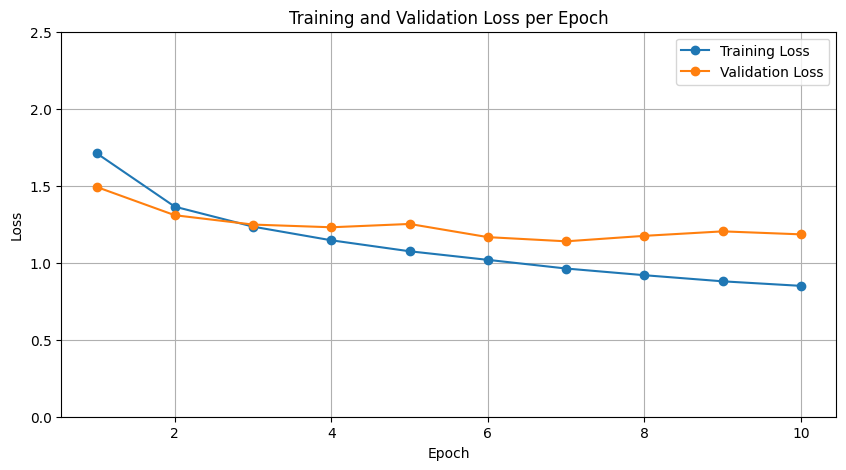

In [ ]:
import matplotlib.pyplot as plt

# Lists to store the training and validation loss for each epoch
train_losses = []
val_losses = []

# Training Loop
for epoch in range(10):  # Loop over the dataset multiple times

    running_loss = 0.0  # Initialize running loss to accumulate loss over mini-batches
    train_class_loss = 0.0  # Initialize training class loss to accumulate loss over the entire epoch
    for i, data in enumerate(trainloader, 0):  # Loop over the data in the trainloader, with batch index starting at 0
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data  # Unpack inputs and labels from the data

        # Zero the parameter gradients
        optimizer.zero_grad()  # Clear the gradients of all optimized parameters

        # Forward pass
        outputs = net(inputs)  # Perform forward pass: compute predicted outputs by passing inputs to the network
        loss = criterion(outputs, labels)  # Compute the loss using the criterion (e.g., cross-entropy loss)

        # Backward pass and optimize
        loss.backward()  # Perform backward pass: compute the gradients of the loss with respect to the parameters
        optimizer.step()  # Perform a single optimization step (parameter update)

        # Accumulate losses
        running_loss += loss.item()
        train_class_loss += loss.item()

        if i % 2000 == 1999:  # Print every 2000 mini-batches
            print(f'Epoch {epoch + 1}, Batches: {(i + 1) // 2000}, Train Class Loss: {running_loss / 2000:.4f}')
            running_loss = 0.0  # Reset running loss after printing

    # Store average training loss for this epoch
    average_train_loss = train_class_loss / len(trainloader)
    train_losses.append(average_train_loss)

    # Print class loss for the entire epoch
    print(f'Epoch {epoch + 1} completed. Average Train Class Loss: {average_train_loss:.4f}')

    # Validation loss calculation
    val_running_loss = 0.0  # Initialize running loss for validation
    val_class_loss = 0.0  # Initialize validation class loss to accumulate loss over the entire epoch
    net.eval()  # Set the network to evaluation mode
    with torch.no_grad():
        for j, data in enumerate(valloader, 0):
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            val_class_loss += loss.item()

            if j % 2000 == 1999:  # Print every 2000 mini-batches
                print(f'Epoch {epoch + 1}, Batches: {(j + 1) // 2000}, Val Class Loss: {val_running_loss / 2000:.4f}')
                val_running_loss = 0.0  # Reset running loss after printing

    average_val_loss = val_class_loss / len(valloader)
    val_losses.append(average_val_loss)
    net.train()  # Set the network back to training mode

    print(f'Epoch {epoch + 1} completed. Average Validation Loss: {average_val_loss:.4f}')

print('Finished Training')

# Visualization of Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.ylim(0, 2.5)
plt.show()

In [ ]:
train_losses

[1.7114431939005852,
 1.3640354446921084,
 1.2341993751466274,
 1.1456116341509752,
 1.0743381511043344,
 1.0185056653877926,
 0.962283882002491,
 0.9188481806297683,
 0.8792125446707424,
 0.8496977764118773]

**Outer Loop: Epochs** <br/>
Epoch: An epoch is a complete pass through the entire training dataset. Multiple epochs allow the model to learn iteratively <br/>
**Get Inputs and Labels** <br/>
Unpack the mini-batch into inputs (features) and labels (targets) <br/>
**Zero Gradients** <br/>
Clear the old gradients from the previous step. This is important to prevent gradient accumulation from multiple backward passes <br/>
**Forward Pass** <br/>
Pass the inputs through the network to get the predicted outputs. This step involves computing the activations of each layer <br/>
**Compute Loss** <br/>
Calculate the loss, which measures the difference between the predicted outputs and the actual labels. The criterion (e.g., cross-entropy loss) defines how this difference is measured <br/>
**Backward Pass and Optimization** <br/>
-Backward Pass: Compute the gradients of the loss with respect to the network parameters using backpropagation. This step determines how much each parameter should change to reduce the loss <br/>
-Optimizer Step: Update the network parameters using the computed gradients. This step modifies the parameters to minimize the loss <br/>
**Accumulate and Print Running Loss** <br/>
-Accumulate Loss: Add the current mini-batch loss to the running total <br/>
-Print Statistics: Every 2000 mini-batches, print the average loss for the last 2000 mini-batches to monitor training progress <br/>
-Reset Running Loss: Reset the running loss to zero after printing to start accumulating for the next 2000 mini-batches <br/>


**SGD Optimizer** <br/>
lr = 0.01, Epochs: 70 <br/>
0.6258 <br/>
**Adam Optimizer** <br/>


Let\'s quickly save our trained model:


In [ ]:
PATH = './cifar_net.pth'  # Define the path where the model's state dictionary will be saved
torch.save(net.state_dict(), PATH) # Save the model's state dictionary to the specified file

See [here](https://pytorch.org/docs/stable/notes/serialization.html) for
more details on saving PyTorch models.

# 5. Test the network on the test data
====================================

We have trained the network for 2 passes over the training dataset. But
we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get
familiar.


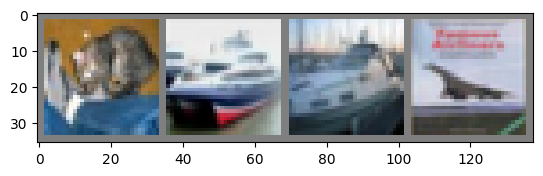

GroundTruth:  cat   ship  ship  plane


In [ ]:
# Create an iterator from the test data loader
dataiter = iter(testloader)

# Get the next batch of test images and their corresponding labels
images, labels = next(dataiter)

# Function to display images
# print images
imshow(torchvision.utils.make_grid(images))  # Create a grid of images and display them using the imshow function
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4))) # Print the ground truth labels for the images in the batch

Next, let\'s load back in our saved model (note: saving and re-loading
the model wasn\'t necessary here, we only did it to illustrate how to do
so):


In [ ]:
#Creates a new instance of the neural network defined by the Net class => Loads the saved parameters (state dictionary) into the newly created network instance

# Create an instance of the neural network defined by the Net class
net = Net()

# Load the saved state dictionary into the network
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above
are:


In [ ]:
outputs = net(images) # Perform a forward pass using the neural network 'net' with the input 'images'

The outputs are energies for the 10 classes. The higher the energy for a
class, the more the network thinks that the image is of the particular
class. So, let\'s get the index of the highest energy:


In [ ]:
# Get the predicted class for each image in the batch
_, predicted = torch.max(outputs, 1)

# Print the predicted class labels for the first 4 images in the batch
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  plane plane


Average Test Loss: 1.1930


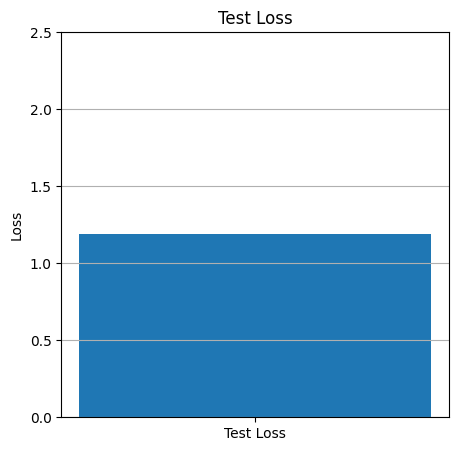

In [ ]:
# Lists to store the training and validation loss for each epoch
test_losses = []

# Separate Test Loss Calculation
test_running_loss = 0.0  # Initialize running loss for test
test_class_loss = 0.0  # Initialize test class loss to accumulate loss over the entire test set
net.eval()  # Ensure the network is in evaluation mode
with torch.no_grad():
    for k, data in enumerate(testloader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item()
        test_class_loss += loss.item()

average_test_loss = test_class_loss / len(testloader)
test_losses.append(average_test_loss)

print(f'Average Test Loss: {average_test_loss:.4f}')

# Visualization of Test Loss as a single point
plt.figure(figsize=(5, 5))
plt.bar(['Test Loss'], [average_test_loss])
plt.ylabel('Loss')
plt.title('Test Loss')
plt.ylim(0, 2.5)
plt.grid(True, axis='y')
plt.show()

The results seem pretty good.

Let us look at how the network performs on the whole dataset.


In [ ]:
#Testing Loop
correct = 0 # Initialize a counter for correctly classified images
total = 0  # Initialize a counter for the total number of images

# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad(): # Disable gradient calculation to speed up the testing process and reduce memory usage
    for data in testloader: # Iterate over the test data
        images, labels = data # Unpack the test data into images and labels
        # Calculate outputs by running images through the network
        outputs = net(images) # Perform a forward pass through the network to get the outputs
        # The class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the class with the highest score
        total += labels.size(0)  # Increment the total count by the number of images in the batch
        correct += (predicted == labels).sum().item() # Increment the correct count by the number of correct predictions

# Print the accuracy of the network on the test images
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 60 %


That looks way better than chance, which is 10% accuracy (randomly
picking a class out of 10 classes). Seems like the network learnt
something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:


In [ ]:
# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}  # Dictionary to store the count of correct predictions for each class
total_pred = {classname: 0 for classname in classes} # Dictionary to store the total number of predictions for each class

# No gradients needed for inference
with torch.no_grad(): # Disable gradient calculation for efficiency
    for data in testloader: # Iterate over the test data
        images, labels = data # Unpack images and labels from the current batch
        outputs = net(images) # Perform a forward pass to get network outputs
        _, predictions = torch.max(outputs, 1)  # Get the class with the highest score for each image
        # Collect the correct predictions for each class
        for label, prediction in zip(labels, predictions): # Iterate over true labels and predicted labels
            if label == prediction: # Check if the prediction is correct
                correct_pred[classes[label]] += 1 # Increment the count of correct predictions for the class
            total_pred[classes[label]] += 1 # Increment the total count of predictions for the class

# Print accuracy for each class
for classname, correct_count in correct_pred.items(): # Iterate over each class and its count of correct predictions
    accuracy = 100 * float(correct_count) / total_pred[classname] # Calculate accuracy for the class
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %') # Print the accuracy for the class

Accuracy for class: plane is 65.0 %
Accuracy for class: car   is 71.5 %
Accuracy for class: bird  is 51.3 %
Accuracy for class: cat   is 55.4 %
Accuracy for class: deer  is 50.2 %
Accuracy for class: dog   is 37.6 %
Accuracy for class: frog  is 61.0 %
Accuracy for class: horse is 69.3 %
Accuracy for class: ship  is 77.8 %
Accuracy for class: truck is 62.9 %
